## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

You can get the data via:

    wget http://pjreddie.com/media/files/cifar.tgz

In [2]:
from fastai.conv_learner import *
PATH = "data/cifar10/"
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlipXY()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
bs=256

### Look at data

In [6]:
data = get_data(32,4)

In [7]:
x,y=next(iter(data.trn_dl))

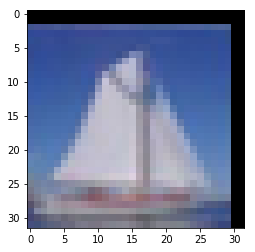

In [12]:
plt.imshow(data.trn_ds.denorm(x)[0]);

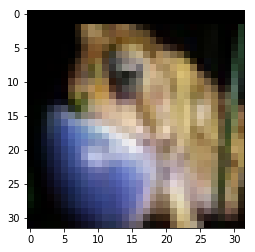

In [13]:
plt.imshow(data.trn_ds.denorm(x)[1]);

## Fully connected model

In [11]:
data = get_data(32,bs)

In [12]:
lr=1e-2

From [this notebook](From https://github.com/KeremTurgutlu/deeplearning/blob/master/Exploring%20Optimizers.ipynb) by our student Kerem Turgutlu:

In [13]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [14]:
def get_learner(m):
    learn = ConvLearner(data, BasicModel(m.cuda()))
    learn.unfreeze()
    return learn

In [29]:
learn = get_learner(SimpleNet([32*32*3, 40,10]))

In [30]:
learn, [o.numel() for o in learn.model.parameters()]

(SimpleNet(
   (layers): ModuleList(
     (0): Linear(in_features=3072, out_features=40)
     (1): Linear(in_features=40, out_features=10)
   )
 ), [122880, 40, 400, 10])

In [31]:
learn.summary()

OrderedDict([('Linear-1',
              OrderedDict([('input_shape', [-1, 3072]),
                           ('output_shape', [-1, 40]),
                           ('trainable', True),
                           ('nb_params', 122920)])),
             ('Linear-2',
              OrderedDict([('input_shape', [-1, 40]),
                           ('output_shape', [-1, 10]),
                           ('trainable', True),
                           ('nb_params', 410)]))])

In [14]:
learn.lr_find()

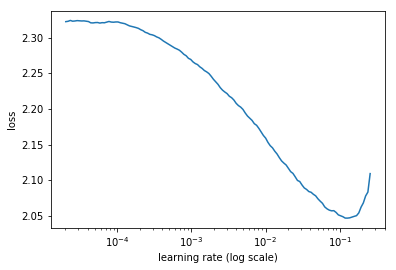

In [30]:
learn.sched.plot()

In [21]:
%time learn.fit(lr, 2)

A Jupyter Widget

[ 0.       1.77314  1.64964  0.41397]                       
[ 1.       1.68107  1.56843  0.4416 ]                       

CPU times: user 1min 8s, sys: 29.1 s, total: 1min 37s
Wall time: 51 s


## CNN

In [58]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, stride=2)
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [59]:
learn = get_learner(ConvNet([3, 20, 40, 80], 10))

In [60]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 15, 15]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 20, 15, 15]),
                           ('output_shape', [-1, 40, 7, 7]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 40, 7, 7]),
                           ('output_shape', [-1, 80, 3, 3]),
                           ('trainable', True),
                           ('nb_params', 28880)])),
             ('AdaptiveMaxPool2d-4',
              OrderedDict([('input_shape', [-1, 80, 3, 3]),
                           ('output_shape', [-1, 80, 1, 1]),
                           ('nb_params', 0)])),
             ('Linear-5',
              OrderedDict

In [58]:
learn.lr_find()

A Jupyter Widget

 81%|████████  | 158/196 [00:18<00:04,  8.57it/s, loss=2.58]

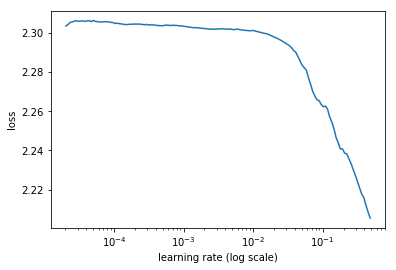

In [59]:
learn.sched.plot()

In [72]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

[ 0.       1.71581  1.62702  0.39902]                       
[ 1.       1.51294  1.51718  0.44375]                       

CPU times: user 1min 7s, sys: 29.2 s, total: 1min 36s
Wall time: 49.3 s


In [61]:
%time learn.fit(1e-1, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.39517  1.32018  0.51689]                       
[ 1.       1.29593  1.24351  0.55576]                       

CPU times: user 1min 6s, sys: 28.6 s, total: 1min 35s
Wall time: 49.2 s


## Refactored

In [23]:
class ConvLayer(nn.Module):
    def __init__(self, ni, nf):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)
        
    def forward(self, x): return F.relu(self.conv(x))

In [45]:
class ConvNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([ConvLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [46]:
learn = get_learner(ConvNet2([3, 20, 40, 80], 10))

In [47]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 560)])),
             ('ConvLayer-2',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-3',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7240)])),
             ('ConvLayer-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 40, 8, 8]),
                 

In [48]:
%time learn.fit(1e-1, 2)

A Jupyter Widget

[ 0.       1.70151  1.64982  0.3832 ]                       
[ 1.       1.50838  1.53231  0.44795]                       

CPU times: user 1min 6s, sys: 28.5 s, total: 1min 35s
Wall time: 48.8 s


In [49]:
%time learn.fit(1e-1, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.51605  1.42927  0.4751 ]                       
[ 1.       1.40143  1.33511  0.51787]                       

CPU times: user 1min 6s, sys: 27.7 s, total: 1min 34s
Wall time: 48.7 s


## BatchNorm

In [18]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [40]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [44]:
learn = get_learner(ConvBnNet([10, 20, 40, 80, 160], 10))

In [21]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 32, 32]),
                           ('output_shape', [-1, 10, 32, 32]),
                           ('trainable', True),
                           ('nb_params', 1480)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 32, 32]),
                           ('output_shape', [-1, 20, 16, 16]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 16, 16]),
                           ('output_shape', [-1, 40, 8, 8]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
              OrderedDict(

In [45]:
%time learn.fit(3e-2, 2)

A Jupyter Widget

[ 0.       1.49611  1.37288  0.50019]                       
[ 1.       1.27695  1.1531   0.5832 ]                       

CPU times: user 1min 14s, sys: 32.3 s, total: 1min 47s
Wall time: 53.1 s


In [46]:
%time learn.fit(1e-1, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.15195  1.02374  0.63975]                       
[ 1.       1.02766  0.92566  0.67158]                       

CPU times: user 1min 17s, sys: 33.5 s, total: 1min 50s
Wall time: 55.1 s


## Deep BatchNorm

In [47]:
class ConvBnNet2(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([BnLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2 in zip(self.layers, self.layers2):
            x = l(x)
            x = l2(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [48]:
learn = get_learner(ConvBnNet2([10, 20, 40, 80, 160], 10))

In [49]:
%time learn.fit(1e-2, 2)

A Jupyter Widget

[ 0.       1.53499  1.43782  0.47588]                       
[ 1.       1.28867  1.22616  0.55537]                       

CPU times: user 1min 22s, sys: 34.5 s, total: 1min 56s
Wall time: 58.2 s


In [50]:
%time learn.fit(1e-2, 2, cycle_len=1)

A Jupyter Widget

[ 0.       1.10933  1.06439  0.61582]                       
[ 1.       1.04663  0.98608  0.64609]                       

CPU times: user 1min 21s, sys: 32.9 s, total: 1min 54s
Wall time: 57.6 s


## Resnet

In [53]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [54]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [55]:
learn = get_learner(Resnet([10, 20, 40, 80, 160], 10))

In [56]:
wd=1e-5

In [57]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.58191  1.40258  0.49131]                       
[ 1.       1.33134  1.21739  0.55625]                       

CPU times: user 1min 27s, sys: 34.3 s, total: 2min 1s
Wall time: 1min 3s


In [58]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.11534  1.05117  0.62549]                       
[ 1.       1.06272  0.97874  0.65185]                       
[ 2.       0.92913  0.90472  0.68154]                        
[ 3.       0.97932  0.94404  0.67227]                        
[ 4.       0.88057  0.84372  0.70654]                        
[ 5.       0.77817  0.77815  0.73018]                        
[ 6.       0.73235  0.76302  0.73633]                        

CPU times: user 5min 2s, sys: 1min 59s, total: 7min 1s
Wall time: 3min 39s


In [59]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.8307   0.83635  0.7126 ]                        
[ 1.       0.74295  0.73682  0.74189]                        
[ 2.       0.66492  0.69554  0.75996]                        
[ 3.       0.62392  0.67166  0.7625 ]                        
[ 4.       0.73479  0.80425  0.72861]                        
[ 5.       0.65423  0.68876  0.76318]                        
[ 6.       0.58608  0.64105  0.77783]                        
[ 7.       0.55738  0.62641  0.78721]                        
[ 8.       0.66163  0.74154  0.7501 ]                        
[ 9.       0.59444  0.64253  0.78106]                        
[ 10.        0.53      0.61772   0.79385]                    
[ 11.        0.49747   0.65968   0.77832]                    
[ 12.        0.59463   0.67915   0.77422]                    
[ 13.        0.55023   0.65815   0.78106]                    
[ 14.        0.48959   0.59035   0.80273]                    
[ 15.        0.4459    0.61823   0.79336]                    
[ 16.   

In [60]:
learn.save('tmp')

In [61]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [62]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.47433498952738201, 0.84460000000000002)

## Resnet 2

In [63]:
class Resnet2(nn.Module):
    def __init__(self, layers, c, p=0.5):
        super().__init__()
        self.conv1 = BnLayer(3, 16, stride=1, kernel_size=7)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        x = self.drop(x)
        return F.log_softmax(self.out(x), dim=-1)

In [70]:
learn = get_learner(Resnet2([16, 32, 64, 128, 256], 10, 0.2))

In [71]:
wd=1e-6

In [72]:
%time learn.fit(1e-2, 2, wds=wd)

A Jupyter Widget

[ 0.       1.7051   1.53364  0.46885]                       
[ 1.       1.47858  1.34297  0.52734]                       

CPU times: user 1min 29s, sys: 35.4 s, total: 2min 4s
Wall time: 1min 6s


In [73]:
%time learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2, wds=wd)

A Jupyter Widget

[ 0.       1.29414  1.26694  0.57041]                       
[ 1.       1.21206  1.06634  0.62373]                       
[ 2.       1.05583  1.0129   0.64258]                       
[ 3.       1.09763  1.11568  0.61318]                       
[ 4.       0.97597  0.93726  0.67266]                        
[ 5.       0.86295  0.82655  0.71426]                        
[ 6.       0.827    0.8655   0.70244]                        

CPU times: user 5min 11s, sys: 1min 58s, total: 7min 9s
Wall time: 3min 48s


In [74]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd)

A Jupyter Widget

[ 0.       0.92043  0.93876  0.67685]                        
[ 1.       0.8359   0.81156  0.72168]                        
[ 2.       0.73084  0.72091  0.74463]                        
[ 3.       0.68688  0.71326  0.74824]                        
[ 4.       0.81046  0.79485  0.72354]                        
[ 5.       0.72155  0.68833  0.76006]                        
[ 6.       0.63801  0.68419  0.76855]                        
[ 7.       0.59678  0.64972  0.77363]                        
[ 8.       0.71126  0.78098  0.73828]                        
[ 9.       0.63549  0.65685  0.7708 ]                        
[ 10.        0.56837   0.63656   0.78057]                    
[ 11.        0.52093   0.59159   0.79629]                    
[ 12.        0.66463   0.69927   0.76357]                    
[ 13.        0.58121   0.64529   0.77871]                    
[ 14.        0.52346   0.5751    0.80293]                    
[ 15.        0.47279   0.55094   0.80498]                    
[ 16.   

In [75]:
learn.save('tmp3')

In [76]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [77]:
metrics.log_loss(y,preds), accuracy(preds,y)

(0.44507397166057938, 0.84909999999999997)